In [1]:
# Installing required libraries

!pip install transformers
! cp /content/drive/MyDrive/DS_2A/processing/optimization.py .

     |████████████████████████████████| 2.0MB 4.4MB/s 
     |████████████████████████████████| 3.2MB 41.2MB/s 
     |████████████████████████████████| 890kB 41.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=2a803783cb4f427f964b2a1914f5884126dedaaf925ae682a90f1d0d3d0e4f0c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import os
import random as rand
from tqdm import tqdm, trange

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

from transformers import AutoTokenizer, AutoModel, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from optimization import BERTAdam
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score

# Data Loading

In [3]:
dataDir = "/content/drive/MyDrive/DS_2A/data"

trainDir = os.path.join(dataDir,"DBLPTrainset.txt")
testDir = os.path.join(dataDir,"DBLPTestset.txt")
testLabelDir = os.path.join(dataDir,"DBLPTestGroundTruth.txt")


In [4]:
trainData = np.loadtxt(trainDir, dtype=str, delimiter="\t")
testData = np.loadtxt(testDir, dtype=str, delimiter="\t")
testLabels = np.loadtxt(testLabelDir, dtype=str, delimiter="\t")

In [5]:
print("Number of training examples: ",np.shape(trainData)[0])
print("Number of test examples: ",np.shape(testData)[0])

print(np.shape(testLabels))


Number of training examples:  21643
Number of test examples:  3373
(3373, 2)


# Data Analysis

In [6]:
print(trainData[0])

titles = trainData[:,2]
journals = trainData[:,1]

print(testData[0])
print(testLabels[0])

testTitles = testData[:,1]
testJournals = testLabels[:,1]

['0' 'ISCAS'
 'Scalable Serial-parallel Multiplier over GF(2m) by Hierarchical Pre-reduction and Input Decomposition.']
['0' 'Fast recursive adaptation for nonlinear filters.']
['0' 'ISCAS']


In [7]:
print("Labels: ",np.unique(journals, return_counts=True)[0])

Labels:  ['INFOCOM' 'ISCAS' 'SIGGRAPH' 'VLDB' 'WWW']


The journal  INFOCOM has 4481 records in training set.
The journal  ISCAS has 7514 records in training set.
The journal  SIGGRAPH has 2678 records in training set.
The journal  VLDB has 3678 records in training set.
The journal  WWW has 3292 records in training set.


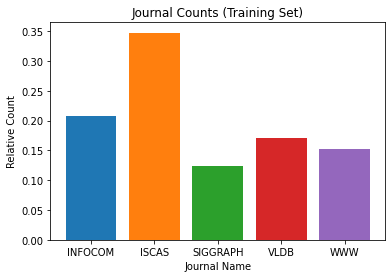

In [8]:
labels, labelCounts = np.unique(journals, return_counts=True)[0], np.unique(journals, return_counts=True)[1]
nTitles = len(titles)

# print("Total number of ")

plt.title("Journal Counts (Training Set)")
plt.ylabel("Relative Count")
plt.xlabel("Journal Name")


for i,journal in enumerate(labels):
  plt.bar(height = labelCounts[i]/nTitles, x = journal)
  print("The journal ", journal, "has", labelCounts[i], "records in training set.")




The journal  INFOCOM has 502 records in test set.
The journal  ISCAS has 2043 records in test set.
The journal  SIGGRAPH has 186 records in test set.
The journal  VLDB has 219 records in test set.
The journal  WWW has 423 records in test set.


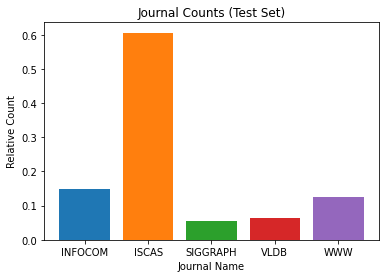

In [9]:
testLabels, testLabelCounts = np.unique(testJournals, return_counts=True)[0], np.unique(testJournals, return_counts=True)[1]

nTestTitles = len(testTitles)

# print("Total number of ")

plt.title("Journal Counts (Test Set)")
plt.ylabel("Relative Count")
plt.xlabel("Journal Name")


for i,journal in enumerate(testLabels):
  plt.bar(height = testLabelCounts[i]/nTestTitles, x = journal)
  print("The journal ", journal, "has", testLabelCounts[i], "records in test set.")

In [10]:
text = " ".join(titles)
stopWords = set(STOPWORDS)
# Create and generate a word cloud image:
wordcloud = WordCloud(width = 2000, height = 2000, 
                      background_color ='white',
                      stopwords = stopWords,
                      min_font_size = 10).generate(text)



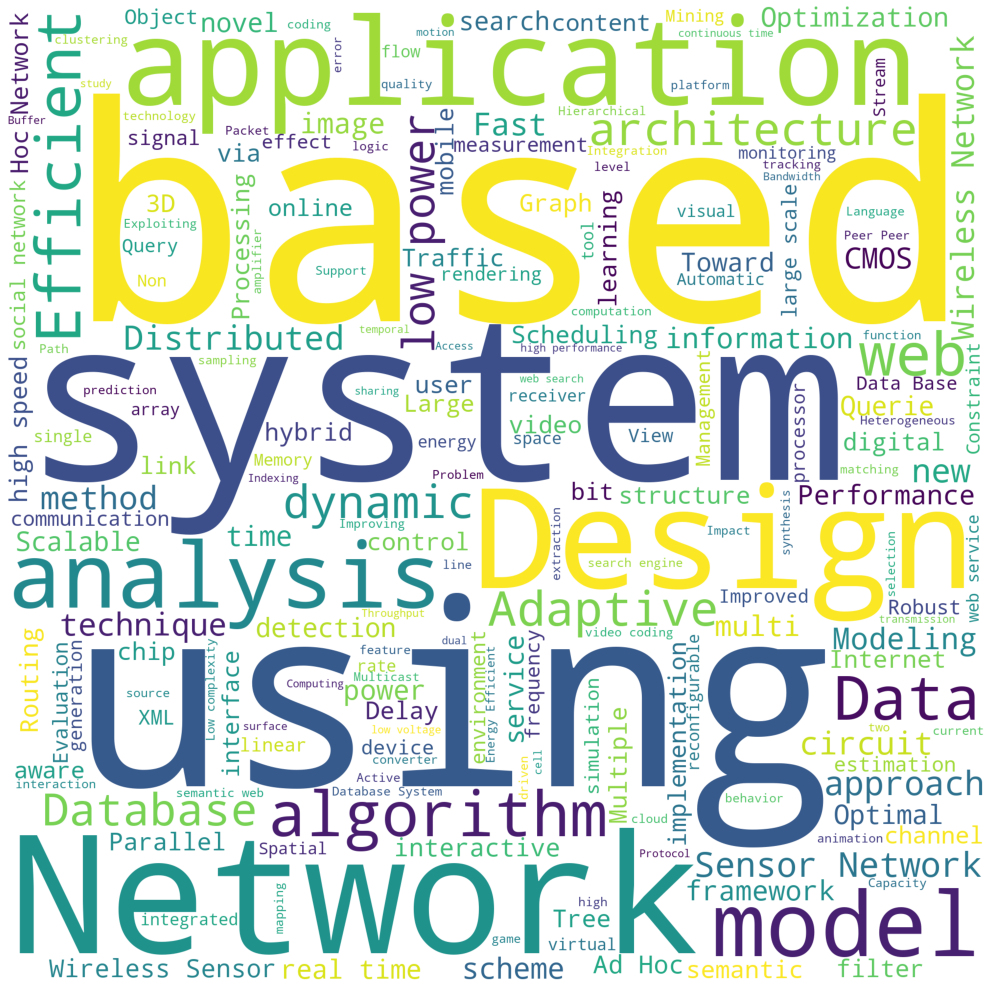

In [11]:
# Display the generated image:
plt.figure(figsize=(18,18))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Preparation for training

In [12]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


def convert_examples_to_features(examples, label_list, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""

    label_map = {}
    for (i, label) in enumerate(label_list):
        label_map[label] = i

    features = []
    for (ex_index, example) in enumerate(tqdm(examples)):
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[0:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = []
        segment_ids = []
        tokens.append("[CLS]")
        segment_ids.append(0)
        for token in tokens_a:
            tokens.append(token)
            segment_ids.append(0)
        tokens.append("[SEP]")
        segment_ids.append(0)

        if tokens_b:
            for token in tokens_b:
                tokens.append(token)
                segment_ids.append(1)
            tokens.append("[SEP]")
            segment_ids.append(1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        while len(input_ids) < max_seq_length:
            input_ids.append(0)
            input_mask.append(0)
            segment_ids.append(0)

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label_map[example.label]

        features.append(
                InputFeatures(
                        input_ids=input_ids,
                        input_mask=input_mask,
                        segment_ids=segment_ids,
                        label_id=label_id))
    return features


def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()


In [13]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

In [35]:
tempString = "Hi. My name is Yash! I study computer science/data science @ UTwente."

tokens = tokenizer.tokenize(tempString)

print("Tokens:", tokens, "\n")

tokenIds = tokenizer.convert_tokens_to_ids(tokens)

print("Token IDs:", tokenIds,"\n")

regeneratedTokens = tokenizer.convert_ids_to_tokens(tokenIds)

print("Rgenerated tokens:", regeneratedTokens, "\n")

regeneratedText = tokenizer.decode(tokenIds)

print("Rgenerated text:", regeneratedText, "\n")

unicodeText = tempString.encode("utf-8")

print(type(unicodeText))

Tokens: ['hi', '.', 'my', 'name', 'is', 'yas', '##h', '!', 'i', 'study', 'computer', 'science', '/', 'data', 'science', '@', 'ut', '##wen', '##te', '.'] 

Token IDs: [5305, 205, 1536, 5147, 165, 25563, 30117, 3190, 259, 527, 2556, 2068, 1352, 453, 2068, 5435, 3315, 23740, 282, 205] 

Rgenerated tokens: ['hi', '.', 'my', 'name', 'is', 'yas', '##h', '!', 'i', 'study', 'computer', 'science', '/', 'data', 'science', '@', 'ut', '##wen', '##te', '.'] 

Rgenerated text: hi. my name is yash! i study computer science / data science @ utwente. 

<class 'bytes'>


In [15]:
valTitles = []
valJournals = []

rand.seed(22)

for i in range(0,100):
  index = rand.randint(0,len(testTitles))
  valTitles.append(testTitles[index])
  valJournals.append(testJournals[index])

In [16]:
def convert_to_unicode(text):
  """Converts `text` to Unicode (if it's not already), assuming utf-8 input."""
  if isinstance(text, str):
      return text
  elif isinstance(text, bytes):
      return text.decode("utf-8", "ignore")


def create_examples(examplesList,set_type):
  """Creates examples for the training and dev sets."""
  examples = []
  for (i, line) in enumerate(examplesList):
    #  if i>50:break
      guid = "%s-%s" % (set_type, i)
      text_a = convert_to_unicode(str(line[0]))
      label = convert_to_unicode(str(line[1]))
      if i%10000==0:
          print(i)
          print("guid=",guid)
          print("text_a=",text_a)
          print("label=",label)
      examples.append(
          InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
  return examples

In [17]:
train_data = np.column_stack((titles, journals))
val_data = np.column_stack((valTitles, valJournals))
test_data = np.column_stack((testTitles, testJournals))

trainExamples = create_examples(train_data,'train')
valExamples = create_examples(val_data,'val')
testExamples = create_examples(test_data,'test')

0
guid= train-0
text_a= Scalable Serial-parallel Multiplier over GF(2m) by Hierarchical Pre-reduction and Input Decomposition.
label= ISCAS
10000
guid= train-10000
text_a= Interactive motion generation from examples.
label= SIGGRAPH
20000
guid= train-20000
text_a= Concepts of Sorting and Projection in a Cellular Array
label= VLDB
0
guid= val-0
text_a= Square-Root Recursive Prediction Error Algorithm for Perceptron-Based Adaptive Equalization Over Frequency Selective Fading Channel.
label= ISCAS
0
guid= test-0
text_a= Fast recursive adaptation for nonlinear filters.
label= ISCAS


In [18]:
trainFeatures = convert_examples_to_features(trainExamples, labels, max_seq_length=112, tokenizer=tokenizer)
valFeatures = convert_examples_to_features(valExamples, labels, max_seq_length=112, tokenizer=tokenizer)
testFeatures = convert_examples_to_features(testExamples, labels, max_seq_length=112, tokenizer=tokenizer)

100%|██████████| 3373/3373 [00:01<00:00, 3158.56it/s]


In [19]:
train_batch_size = 32
num_train_epochs = 4

numTrainSteps = int (len(trainExamples) / train_batch_size * num_train_epochs)
print("Number of training steps = ", numTrainSteps)

Number of training steps =  2705


In [20]:
all_input_ids = torch.tensor([f.input_ids for f in trainFeatures], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in trainFeatures], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in trainFeatures], dtype=torch.long)
all_label_ids = torch.tensor([f.label_id for f in trainFeatures], dtype=torch.long)

In [21]:
print("Number of input ids: ", len(all_input_ids))
print("Number of input masks: ", len(all_input_mask))
print("Number of segment ids: ", len(all_segment_ids))
print("Number of label ids: ", len(all_label_ids))

Number of input ids:  21643
Number of input masks:  21643
Number of segment ids:  21643
Number of label ids:  21643


In [22]:
trainData = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

print (trainData[0])

(tensor([  102, 14628,  8595,   579,  3098, 17491,   573, 10622,   145,   170,
        30119,   546,   214,  7540,   382,   579,  2135,   137,  1653,  5720,
          205,   103,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [23]:
train_sampler = RandomSampler(trainData)
train_dataloader = DataLoader(trainData, sampler=train_sampler, batch_size=train_batch_size)

In [24]:
model = BertForSequenceClassification.from_pretrained("allenai/scibert_scivocab_uncased", num_labels = len(labels))

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

# Training and Evaluation

In [25]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [26]:
model.to(device)



BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [27]:
no_decay = ['bias', 'gamma', 'beta']
optimizer_parameters = [
      {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.01},
      {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.0}
      ]

In [28]:
learning_rate = 3e-5
warmup_proportion = 1e-4

optimizer = BERTAdam(optimizer_parameters,
                      lr=learning_rate,
                      warmup=warmup_proportion,
                      t_total=numTrainSteps)

In [29]:
def eval(modelName, evalType, featureSet, batchSize):
  
  eval_input_ids = torch.tensor([f.input_ids for f in featureSet], dtype=torch.long)
  eval_input_mask = torch.tensor([f.input_mask for f in featureSet], dtype=torch.long)
  eval_segment_ids = torch.tensor([f.segment_ids for f in featureSet], dtype=torch.long)
  eval_label_ids = torch.tensor([f.label_id for f in featureSet], dtype=torch.long)

  eval_data = TensorDataset(eval_input_ids, eval_input_mask, eval_segment_ids, eval_label_ids)
  eval_sampler = SequentialSampler(eval_data)
  eval_dataloader = DataLoader(eval_data, sampler = eval_sampler, batch_size=batchSize, shuffle=False)

  modelName.eval()

  test_loss, test_accuracy = 0, 0
  nb_test_steps, nb_test_examples = 0, 0
  predictions = []

  for input_ids, input_mask, segment_ids, label_ids in eval_dataloader:
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    label_ids = label_ids.to(device)

    # input_ids = torch.transpose(input_ids, 0, 1)
    # input_mask = torch.transpose(input_mask, 0, 1)
    # segment_ids = torch.transpose(segment_ids, 0, 1)


    with torch.no_grad():
      modelOutput= model(input_ids = input_ids, token_type_ids = segment_ids, attention_mask = input_mask, labels = label_ids)

    # return modelOutput

    tmp_test_loss, logits = modelOutput.loss, modelOutput.logits  
    logits = F.softmax(logits, dim=-1)
    logits = logits.detach().cpu().numpy()
    label_ids = label_ids.to('cpu').numpy()
    outputs = np.argmax(logits, axis=1)

    predictions.append(outputs)

    tmp_test_accuracy=np.sum(outputs == label_ids)

    test_loss += tmp_test_loss.mean().item()
    test_accuracy += tmp_test_accuracy

    nb_test_examples += input_ids.size(0)
    nb_test_steps += 1

  test_loss = test_loss / nb_test_steps
  test_accuracy = test_accuracy / nb_test_examples
  trueOutput = [x.label_id for x in featureSet]
  trueOutput = np.asarray(trueOutput)
  predictions = np.asarray(predictions).flatten()
  
  if (evalType == 'validation'):
    
    confusionMatrix = confusion_matrix(trueOutput,predictions)
  
    macroF1 = f1_score(trueOutput,predictions, average = 'macro')
    microF1 = f1_score(trueOutput,predictions, average = 'micro')
    weightedF1 = f1_score(trueOutput,predictions, average = 'weighted')

    macroRecall = recall_score(trueOutput, predictions, average='macro')
    microRecall = recall_score(trueOutput, predictions, average='micro')
    weightedRecall = recall_score(trueOutput, predictions, average='weighted')

    macroPrecision = precision_score(trueOutput, predictions, average='macro')
    microPrecision = precision_score(trueOutput, predictions, average='micro')
    weightedPrecision = precision_score(trueOutput, predictions, average='weighted')


    return [confusionMatrix,"F Scores:", macroF1, microF1, weightedF1, "Recall scores:", macroRecall, microRecall,
            weightedRecall, "Precision scores", macroPrecision, microPrecision, weightedPrecision]

  elif (evalType == 'test'):

    return predictions

  # return predictions

In [30]:
global_step = 0
epoch = 0
n_gpu = 1
gradient_accumulation_steps = 10


for _ in trange(int(num_train_epochs), desc="Epoch"):
    epoch += 1
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)

        input_ids, input_mask, segment_ids, label_ids = batch
        # print(input_ids.shape,input_mask.shape,segment_ids.shape)
        stepLoss = 0

        # input_ids = torch.transpose(input_ids, 0, 1)
        # input_mask = torch.transpose(input_mask, 0, 1)
        # segment_ids = torch.transpose(segment_ids, 0, 1)
        # print(input_ids.shape,input_mask.shape,segment_ids.shape)

        bertOutput = model(input_ids = input_ids, token_type_ids = segment_ids, attention_mask = input_mask, labels = label_ids)

        loss = bertOutput.loss
        stepLoss += loss
        if n_gpu > 1:
            loss = loss.mean() # mean() to average on multi-gpu.
        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        loss.backward()
        tr_loss += loss.item()
        nb_tr_examples += input_ids.size(0)
        nb_tr_steps += 1
        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()    # We have accumulated enought gradients
            model.zero_grad()
            global_step += 1
    print("Train Loss:",stepLoss)
    valMicroF1 = eval(model, evalType = 'validation', featureSet = valFeatures, batchSize = 25)[3]
    print('Val Micro F1:', valMicroF1)

    # if args.do_save_model:
    #     if n_gpu > 1:
    #         torch.save(model.module.state_dict(), os.path.join(args.output_dir, f'model_ep_{epoch}.bin'))
    #     else:
    #         torch.save(model.state_dict(), os.path.join(args.output_dir, f'model_ep_{epoch}.bin'))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/content/optimization.py:146: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train Loss: tensor(0.5866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  25%|██▌       | 1/4 [12:14<36:43, 734.43s/it]

Val Micro F1: 0.89
Train Loss: tensor(0.1728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  50%|█████     | 2/4 [24:28<24:28, 734.27s/it]

Val Micro F1: 0.89
Train Loss: tensor(0.2685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  75%|███████▌  | 3/4 [36:42<12:14, 734.22s/it]

Val Micro F1: 0.85
Train Loss: tensor(0.0060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 100%|██████████| 4/4 [48:56<00:00, 734.11s/it]

Val Micro F1: 0.8399999999999999


In [31]:
testFeaturesTemp = testFeatures
testResults = eval(model, evalType = 'test', featureSet = testFeaturesTemp, batchSize = 500)

# print(testResults)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [32]:
temp = np.concatenate((testResults[0], testResults[1], testResults[2],
                       testResults[3], testResults[4], testResults[5],
                       testResults[6]))


In [37]:
predictions = temp
trueOutput = [x.label_id for x in testFeatures]
trueOutput = np.asarray(trueOutput)

confusionMatrix = confusion_matrix(trueOutput,predictions)

macroF1 = f1_score(trueOutput,predictions, average = 'macro')
microF1 = f1_score(trueOutput,predictions, average = 'micro')
weightedF1 = f1_score(trueOutput,predictions, average = 'weighted')

macroRecall = recall_score(trueOutput, predictions, average='macro')
microRecall = recall_score(trueOutput, predictions, average='micro')
weightedRecall = recall_score(trueOutput, predictions, average='weighted')

macroPrecision = precision_score(trueOutput, predictions, average='macro')
microPrecision = precision_score(trueOutput, predictions, average='micro')
weightedPrecision = precision_score(trueOutput, predictions, average='weighted')


print ("Confusion Matrix:", "\n", confusionMatrix, "\n", 
       "F Scores:", "\n", "macro F1:", macroF1,"micro F1:", microF1, "weighted F1:", weightedF1, "\n",
       "Recall scores:", "\n", "macro Recall:", macroRecall, "micro Recall:", microRecall, "weighted Recall:", weightedRecall, "\n",
       "Precision scores", "\n", "macro Precision:", macroPrecision, "micro Precision:", microPrecision, "weighted Precision:", weightedPrecision)

Confusion Matrix: 
 [[ 405   19   14   37   27]
 [  58 1896   37   47    5]
 [   1   11  165    7    2]
 [  12    1    3  174   29]
 [  19    5   11   47  341]] 
 F Scores: 
 macro F1: 0.8079407022575257 micro F1: 0.883782982508153 weighted F1: 0.8884364891478147 
 Recall scores: 
 macro Recall: 0.8445167584660611 micro Recall: 0.883782982508153 weighted Recall: 0.883782982508153 
 Precision scores 
 macro Precision: 0.7837382591579751 micro Precision: 0.883782982508153 weighted Precision: 0.8977958720581347


In [34]:
# output_dir = "/content/drive/MyDrive/DS_2A/models"
# torch.save(model.state_dict(), os.path.join(output_dir, f'model_ep_{epoch}.bin'))